# Bước 6: Phân cụm khách hàng từ Luật kết hợp (Association Rules → Clustering)

Notebook này lấy **kết quả luật kết hợp** (Apriori/FP-Growth) và biến chúng thành **đặc trưng** để phân cụm khách hàng bằng K-Means.

## Ý tưởng cốt lõi
- Mỗi luật có dạng: **Antecedent → Consequent**
- Với mỗi khách hàng, ta kiểm tra: khách đó đã từng mua **đủ antecedents** của luật hay chưa.
- Mỗi luật trở thành một feature (0/1 hoặc có trọng số theo lift/confidence).
- (Tuỳ chọn) Ghép thêm **RFM** để phân cụm ổn định hơn.


## Parameters
Gán tham số để chạy bằng papermill.


In [1]:
# PARAMETERS (for papermill)

# Input
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"  # hoặc rules_fpgrowth_filtered.csv

# Feature engineering
TOP_K_RULES = 200
SORT_RULES_BY = "lift"      # lift | confidence | support
WEIGHTING = "lift"          # none | lift | confidence | support | lift_x_conf
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False

# Clustering
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None            # None => chọn theo silhouette, hoặc đặt số cụ thể (vd 5)
RANDOM_STATE = 42

# Output
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"

# Visual
PROJECTION_METHOD = "pca"   # pca | svd
PLOT_2D = True


In [2]:
# Parameters
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"
TOP_K_RULES = 200
SORT_RULES_BY = "lift"
WEIGHTING = "lift"
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None
RANDOM_STATE = 42
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"
PROJECTION_METHOD = "pca"
PLOT_2D = True


## Set up


In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import RuleBasedCustomerClusterer


## Load cleaned data & rules


In [4]:
df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(df_clean.shape)
df_clean.head()


(485123, 11)


C:\Users\Admin\AppData\Local\Temp\ipykernel_11952\4012976299.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,HourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,017850,United Kingdom,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,017850,United Kingdom,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8


In [5]:
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)
print('Customer × Item:', customer_item_bool.shape)

rules_df = clusterer.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)
print('Rules used:', rules_df.shape)
rules_df.head()


Customer × Item: (3921, 4007)
Rules used: (175, 17)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
0,frozenset({'WOODEN HEART CHRISTMAS SCANDINAVIA...,frozenset({'WOODEN STAR CHRISTMAS SCANDINAVIAN'}),0.028245,0.026580,0.020421,0.722986,27.200282,1.0,0.019670,3.513977,0.991233,0.593548,0.715422,0.745627,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN → WOODEN S...
1,frozenset({'WOODEN STAR CHRISTMAS SCANDINAVIAN'}),frozenset({'WOODEN HEART CHRISTMAS SCANDINAVIA...,0.026580,0.028245,0.020421,0.768267,27.200282,1.0,0.019670,4.193430,0.989538,0.593548,0.761532,0.745627,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN → WOODEN HE...
2,"frozenset({'GREEN REGENCY TEACUP AND SAUCER', ...",frozenset({'PINK REGENCY TEACUP AND SAUCER'}),0.038844,0.038955,0.027301,0.702857,18.043004,1.0,0.025788,3.234288,0.982750,0.540659,0.690813,0.701856,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY...",PINK REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY..."
3,"frozenset({'ROSES REGENCY TEACUP AND SAUCER ',...",frozenset({'GREEN REGENCY TEACUP AND SAUCER'}),0.030242,0.051717,0.027301,0.902752,17.455471,1.0,0.025737,9.751207,0.972110,0.499492,0.897449,0.715325,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ...",GREEN REGENCY TEACUP AND SAUCER,"PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY ..."
4,"frozenset({'GREEN REGENCY TEACUP AND SAUCER', ...",frozenset({'ROSES REGENCY TEACUP AND SAUCER '}),0.031963,0.053049,0.027301,0.854167,16.101399,1.0,0.025606,6.493377,0.968861,0.473077,0.845997,0.684406,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ...",ROSES REGENCY TEACUP AND SAUCER,"GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY ..."


## Build features (Rules → Features) + (optional) RFM


In [6]:
X, meta = clusterer.build_final_features(
    weighting=WEIGHTING,
    use_rfm=USE_RFM,
    rfm_scale=RFM_SCALE,
    rule_scale=RULE_SCALE,
    min_antecedent_len=MIN_ANTECEDENT_LEN,
)
print('X shape:', X.shape)
meta.head()


X shape: (3921, 178)


,CustomerID,Recency,Frequency,Monetary
0,000nan,1,1373,1716830.53
1,012346,326,1,77183.60
2,012747,2,11,4196.01
3,012748,1,209,33719.73
4,012749,4,5,4090.88


## Choose K (silhouette)


In [7]:
sil_df = clusterer.choose_k_by_silhouette(
    X,
    k_min=K_MIN,
    k_max=K_MAX,
    random_state=RANDOM_STATE,
)
sil_df


,k,silhouette
0,2,0.546421
1,3,0.447539
2,8,0.432916
3,7,0.429474
4,6,0.416136
5,5,0.413753
6,4,0.396081
7,9,0.300016
8,10,0.273153


In [8]:
best_k = int(sil_df.loc[0, 'k'])
k = best_k if N_CLUSTERS is None else int(N_CLUSTERS)
print('Chosen k =', k)


Chosen k = 2


## Fit KMeans & save results


In [9]:
labels = clusterer.fit_kmeans(X, n_clusters=k, random_state=RANDOM_STATE)
meta_out = meta.copy()
meta_out['cluster'] = labels

# Lưu
os.makedirs(os.path.dirname(OUTPUT_CLUSTER_PATH), exist_ok=True)
meta_out.to_csv(OUTPUT_CLUSTER_PATH, index=False)
print('Saved:', OUTPUT_CLUSTER_PATH)
meta_out.head()


Saved: data/processed/customer_clusters_from_rules.csv


,CustomerID,Recency,Frequency,Monetary,cluster
0,000nan,1,1373,1716830.53,1
1,012346,326,1,77183.60,0
2,012747,2,11,4196.01,0
3,012748,1,209,33719.73,1
4,012749,4,5,4090.88,0


## Quick profiling


In [10]:
profile_cols = ['cluster'] + ([c for c in ['Recency','Frequency','Monetary'] if c in meta_out.columns])
summary = meta_out.groupby('cluster').agg({
    'CustomerID': 'count',
    **{c:'mean' for c in profile_cols if c!='cluster'}
}).rename(columns={'CustomerID':'n_customers'}).sort_values('n_customers', ascending=False)
summary


,n_customers,Recency,Frequency,Monetary
cluster,,,,
0,3574,97.571908,3.521265,1485.590091
1,347,36.703170,15.665706,10708.135735


## 2D visualization (PCA/SVD)


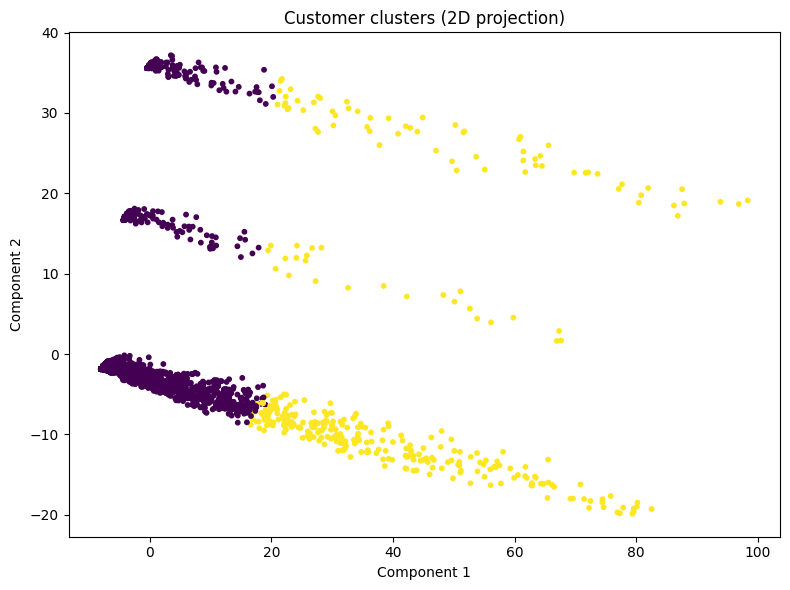

In [11]:
if PLOT_2D:
    Z = clusterer.project_2d(X, method=PROJECTION_METHOD, random_state=RANDOM_STATE)
    plt.figure(figsize=(8,6))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
    plt.title('Customer clusters (2D projection)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()
